## RL and Advanced DL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

#### Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 
Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
1. численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
2. туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
3. игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
4. игрок может совершать одно из двух действий:
 - hit  — взять ещё одну карту;
 - stand — не брать больше карт;
5. если сумма очков у игрока на руках больше 21, он проигрывает (bust);
6. если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
7. после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
8. в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).


Именно этот простейший вариант блекджека реализован в OpenAI Gym:  
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py  
<b>1.</b> Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.  
<b>2.</b> Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.   
<b>3.</b> Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.  

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
from tqdm import tqdm

In [2]:
env = gym.make('Blackjack-v1')
env.natural = True

In [3]:
available_actions = [True, False]
available_sums = list(range(4, 32))
available_cards = list(range(1, 11))

Считала средний выигрыш для конечной лучшей стратегии (не знаю, насколько это верно, т.к. читала в чате, что есть и другие варианты подсчета)

In [4]:
def calc_mean_reward(environment, pi, n):
    rewards = []
    for _ in range(n):
        state = env.reset()
        end = False
        current_reward = 0
        while not end:
            action = pi[state]
            state, reward, end, info = env.step(action)
            current_reward += reward
        rewards.append(current_reward)
    return np.mean(rewards)

In [30]:
S = list(itertools.product(available_sums, available_cards, available_actions))
# 19, 20 или 21 stand pi
easy_pi = dict(zip(S, [1 if (state[0] < 19 or state[0] > 21) else 0 for state in S]))
easy_pi_mean_reward = calc_mean_reward(env, easy_pi, 100_000)

In [31]:
print("'19, 20, 21 -> Stand' strategy mean reward: ", easy_pi_mean_reward)

'19, 20, 21 -> Stand' strategy mean reward:  -0.19362


In [7]:
def get_action(Q, state, A, eps):
    if random.random() < (1 - eps):
        pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
        action = pi[state]
    else:
        action = random.choice(A)
    return action
    
def Q_learning(env, A, Q, num_episodes, alpha, epsilon, gamma):
    for _ in tqdm(range(num_episodes)):
        state = env.reset()
        end = False
        while not end:
            action = get_action(Q, state, A, epsilon)
            new_state, reward, end, info = env.step(action)
            Q[state][action] = Q[state][action] + alpha * (reward + gamma * max(Q[new_state]) - Q[state][action])
            state = new_state  
    return Q

In [32]:
env = gym.make('Blackjack-v1')
env.natural = True

A = (0, 1)
# инициализируем Q
Q = dict(zip(S, np.zeros((len(S), len(A)))))

In [42]:
# гиперпараметры (подобраны эмпирически)
num_episodes = 100_000
alpha = 0.001
epsilon = 0.8
gamma = 0.9

In [43]:
Q = Q_learning(env, A, Q, num_episodes=num_episodes, alpha=alpha, epsilon=epsilon, gamma=gamma)
pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
reward_mean = calc_mean_reward(env, pi, n=100_000)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:48<00:00, 2063.75it/s]


In [44]:
print("'Q learning with default BlackjackEnv' mean reward: ", reward_mean)

'Q learning with default BlackjackEnv' mean reward:  -0.10481


In [45]:
def get_mean_reward_while_learning(env, A, Q, num_episodes, num_playes, step, alpha, epsilon, gamma):
    rewards = []
    for i in tqdm(range(num_episodes)):
        state = env.reset()
        end = False
        while not end:
            action = get_action(Q, state, A, epsilon)
            new_state, reward, end, info = env.step(action)
            Q[state][action] = Q[state][action] + alpha * (reward + gamma * max(Q[new_state]) - Q[state][action])
            state = new_state 
        if i % step == 0:
            pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
            mean_reward = calc_mean_reward(env, pi, num_playes)
            rewards.append(mean_reward)    
    return rewards

In [46]:
def plot_mean_rewards(mean_rewards, num_episodes, step):
    plt.figure(figsize=(10, 7))
    indicies = np.arange(0, num_episodes, step)
    plt.plot(indicies, mean_rewards, linewidth=1.5)
    plt.xlabel("Number of episodes played")
    plt.ylabel("Average reward")
    plt.title("Average reward during training")
    plt.xlim(left=0)
    plt.xlim(right=num_episodes)
    plt.minorticks_on()
    plt.grid(True)

In [47]:
step = 500
num_playes = 10_000
Q = dict(zip(S, np.zeros((len(S), len(A)))))
mean_rewards = get_mean_reward_while_learning(env, A, Q, num_episodes=num_episodes, num_playes=num_playes,
                                   step=step, alpha=alpha, epsilon=epsilon, gamma=gamma)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [05:03<00:00, 329.71it/s]


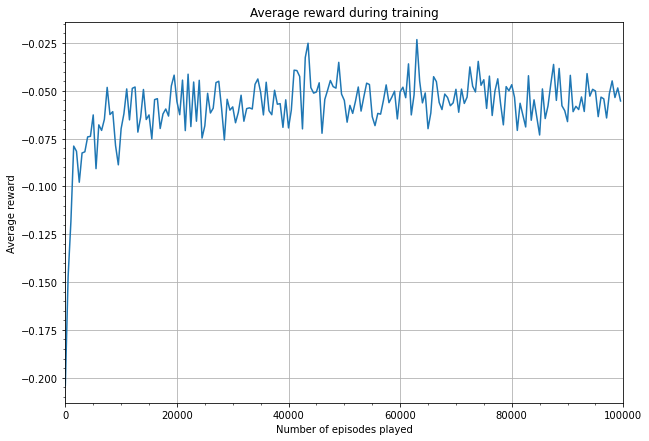

In [48]:
plot_mean_rewards(mean_rewards, num_episodes, step)

#### Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.  
<b>4.</b> Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.  
<b>5.</b> Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [49]:
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackDoubleEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 0:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 1:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        else: # double: add a card to players hand, end the game, double reward
            self.player.append(draw_card(self.np_random))
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer)) * 2
             
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [17]:
env = BlackjackDoubleEnv()
env.natural = True

# (hit, stand, double)
A = (0, 1, 2)
Q = dict(zip(S, np.zeros((len(S), len(A)))))
S = list(itertools.product(range(4, 32), range(1, 11), (True, False)))

In [18]:
# гиперпараметры (подобраны эмпирически)
num_episodes = 50_000
alpha = 0.005
epsilon = 0.8
gamma = 1

In [19]:
Q = Q_learning(env, A, Q, num_episodes=num_episodes, alpha=alpha, epsilon=epsilon, gamma=gamma)
pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
reward_mean = calc_mean_reward(env, pi, n=100_000)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:09<00:00, 5373.72it/s]


In [20]:
print("'Q learning with 'double' action mean reward: ", reward_mean)

'Q learning with 'double' action mean reward:  -0.05678


In [21]:
step = 500
Q = dict(zip(S, np.zeros((len(S), len(A)))))
mean_rewards = get_mean_reward_while_learning(env, A, Q, num_episodes=num_episodes, num_playes=num_playes,
                                   step=step, alpha=alpha, epsilon=epsilon, gamma=gamma)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:06<00:00, 755.42it/s]


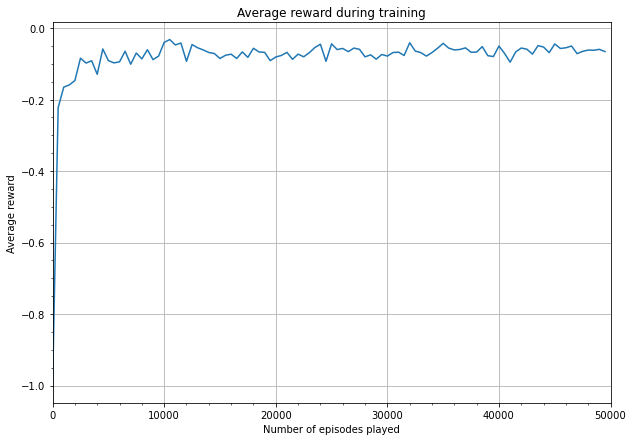

In [22]:
plot_mean_rewards(mean_rewards, num_episodes, step)

### Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.  

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.  

<b> 6. </b> Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).  
<b> 7. </b>Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [23]:
"""Для подсчета карт использовала систему 'Половинки', описаннную в статье на Википедии,
    т.к. она лишена недостатвков системы подсчёта 'Плюс-минус'"""

class BlackjackDoubleCardsCountEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(         # пересчитать пространство для подсчета               
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2), spaces.Discrete(100))
        )
        self.seed()
        # стандартная колода
        self.standart_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        # шуз на 4 колоды
        self.deck = self.standart_deck * 4
        # 'счет' карт
        self.cards_count = 0
        # числовые значения для карт
        self.mathing = {
            1: -1,
            2: 0.5,
            3: 0.5,
            4: 1,
            5: 1.5,
            6: 1,
            7: 0.5,
            8: 0,
            9: -0.5,
            10: -1,
        }

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab
    
    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        # убрать карту из колоды при раздаче
        self.deck.remove(card)
#         print(self.deck)
        return card

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def count(self, card):
        self.cards_count += self.mathing[card] 

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 0:  # hit: add a card to players hand and return
            # подсчитываем полученную из колоды карту
            card = self.draw_card(self.np_random)
            self.count(card)
            self.player.append(card)
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 1:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
            # подсчитываем все карты диллера, кроме открытой
            for card in self.dealer[1:]:
                self.count(card)      
        else: # double: add a card to players hand, end the game, double reward
            # подсчитываем полученную из колоды карту
            card = self.draw_card(self.np_random)
            self.count(card)
            self.player.append(card)
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            # подсчитываем все карты диллера, кроме открытой
            for card in self.dealer[1:]:
                self.count(card)   
            reward = cmp(score(self.player), score(self.dealer)) * 2
             
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.cards_count)

    def reset(self):
        if len(self.deck) < 15:
            self.deck = self.standart_deck * 4
            self.cards_count = 0
        cards = self.draw_hand(self.np_random)
        self.dealer = cards
        for card in cards:
            self.count(card)  
        cards = self.draw_hand(self.np_random)
        self.player = cards
        for card in cards:
            self.count(card)  
#         print(self.deck)
        return self._get_obs()

In [52]:
env = BlackjackDoubleCardsCountEnv()
env.natural = True

A = (0, 1, 2)
max_count = 4 * (1 * 1.5 + 3 * 0.5 + 2 * 1)
min_count = 4 * (4 * (-1) - 0.5 - 1)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False), np.arange(min_count, max_count, 0.5)))
Q = dict(zip(S, np.zeros((len(S), len(A)))))

In [53]:
# hyperparameters
num_episodes = 100_000
alpha = 0.0001
epsilon = 0.9
gamma = 0.9

In [54]:
Q = Q_learning(env, A, Q, num_episodes=num_episodes, alpha=alpha, epsilon=epsilon, gamma=gamma)
pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
reward_mean = calc_mean_reward(env, pi, n=500_000)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [20:29<00:00, 81.30it/s]


In [57]:
print("'Q learning with double and cards count mean reward: ", reward_mean)

'Q learning with double and cards count mean reward:  -0.098072


In [56]:
env = BlackjackDoubleCardsCountEnv()
env.natural = True

step = 1000
Q = dict(zip(S, np.zeros((len(S), len(A)))))
mean_rewards = get_mean_reward_while_learning(env, A, Q, num_episodes=num_episodes, num_playes=num_playes,
                                   step=step, alpha=alpha, epsilon=epsilon, gamma=gamma)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [23:13<00:00, 71.78it/s]


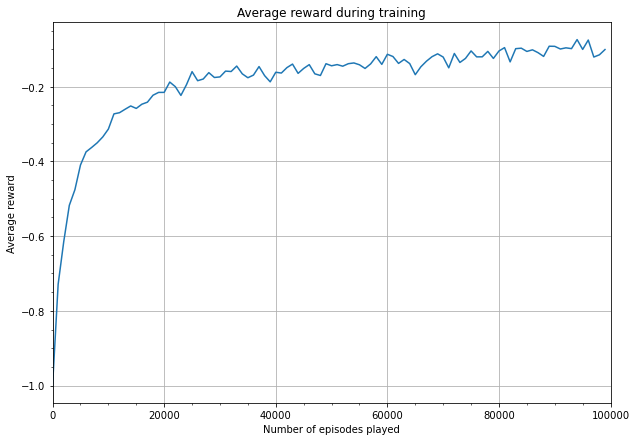

In [58]:
plot_mean_rewards(mean_rewards, num_episodes, step)

<b>Выводы:</b> в целом каждая следующая реализация в среднем показывает чуть лучший результат, чем предыдущая (кроме последней). Обыграть казино, к сожалению, так и не удалось, но думаю, что дальше все зависело от правильной настройки гиперпараметров на которую уже не хватило времени.
Что касается последней реализации, то исходя из графиков можно сделать вывод, что при более длительном обучении есть потенциал выйти в плюс, но на это тоже нужно больше времени. 